# Using Quantization Aware Training in TensorFlow

In this tutorial, we will discuss how to train a Quantization Aware Model using TensorFlow Model Optimization Toolkit (TF-MOT). Quantization Aware Training allows for reduced precision representations of weights and, optionally, activations for both storage and computation. This is particularly important for deploying models on hardware and platforms that don't support floating point operations.



In [ ]:
import sys
!{sys.executable} -m pip install numpy tensorflow tensorflow_model_optimization matplotlib

## Dataset Preparation
We will use the popular MNIST dataset for this example. First, let's import the required libraries and load the dataset.

In [8]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

We have a total of 70,000 grayscale images, each with a dimension of 28 x 28 pixels. 60,000 images are for training and the remaining 10,000 are for testing.

Now, we need to preprocess our data. We need to flatten our data and then normalize it.


In [9]:
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to range [0, 1]
x_train /= 255
x_test /= 255

## Model Definition and Training
We will use a simple feedforward neural network (also known as Multi-layer Perceptron) for this task. Our model will have two hidden layers each with 256 neurons.

In [10]:
from tensorflow.keras import layers

num_classes = 10

model = keras.Sequential(
    [
        layers.Dense(256, input_shape=(28*28,), activation='relu'), 
        layers.Dense(num_classes, activation='softmax')
    ]
)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


Now let's train this model on our training data.

In [11]:
batch_size = 256
epochs = 10
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2)


Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2524 - accuracy: 0.9265 - val_loss: 0.1454 - val_accuracy: 0.9587
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1036 - accuracy: 0.9685 - val_loss: 0.0984 - val_accuracy: 0.9695
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0673 - accuracy: 0.9794 - val_loss: 0.0865 - val_accuracy: 0.9734
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0480 - accuracy: 0.9853 - val_loss: 0.0867 - val_accuracy: 0.9734
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0338 - accuracy: 0.9897 - val_loss: 0.0841 - val_accuracy: 0.9756
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0255 - accuracy: 0.9920 - val_loss: 0.0848 - val_accuracy: 0.9759
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0886 - val_accuracy:

At this point, we have trained a regular model.



## Making the Model Quantization Aware
Now, let's transform our model into a quantization aware model. We use the TensorFlow Model Optimization Toolkit for this.


In [12]:
import tensorflow_model_optimization as tfmot

# Apply quantization to the layers
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for 'quantization aware'
q_aware_model = quantize_model(model)

# 'quantize_model' requires a recompile
q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 784)               3         
 yer)                                                            
                                                                 
 quant_dense (QuantizeWrapp  (None, 256)               200965    
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                2575      
 pperV2)                                                         
                                                                 
Total params: 203543 (795.09 KB)
Trainable params: 203530 (795.04 KB)
Non-trainable params: 13 (52.00 Byte)
_________________________________________________________________


We have now created a new model, q_aware_model, which is a quantization aware version of our original model. Now we can train this model exactly like our original model.

In [13]:
batch_size = 256
epochs = 10
history = q_aware_model.fit(x_train, y_train,
                            epochs=epochs,
                            validation_split=0.2)

scores, acc = q_aware_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', acc)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.1027 - val_accuracy: 0.9756
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0967 - val_accuracy: 0.9774
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.1192 - val_accuracy: 0.9757
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.1106 - val_accuracy: 0.9774
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.1066 - val_accuracy: 0.9775
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.1104 - val_accuracy: 0.9773
Epoch 7/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.1290 - val_accuracy:

## Converting to TFLite Format
Now, we will convert our model to TFLite format, which is a format optimized for on-device machine learning.

In [14]:
import tensorflow as tf

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

# Indicate that you want to perform default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides your test data's numpy arrays
def representative_data_gen():
  for i in range(500):
    yield [x_test[i:i+1]]

# Use the generator function to guide the quantization process
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("q_aware_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/y0/97f_vm5j41z458vgrn6h2xd40000gn/T/tmpxdk12j91/assets


INFO:tensorflow:Assets written to: /var/folders/y0/97f_vm5j41z458vgrn6h2xd40000gn/T/tmpxdk12j91/assets
/Users/raphael/anaconda3/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-05-31 11:40:16.356043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 11:40:16.356071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 11:40:16.356367: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/y0/97f_vm5j41z458vgrn6h2xd40000gn/T/tmpxdk12j91
2023-05-31 11:40:16.357411: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-05-31 11:40:16.357421: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/y0/97f_vm5j41z458vgrn6h2xd40000gn

206504

## Testing the Quantized Model
Now that we have trained a quantization-aware model and converted it to the TFLite format, we can now perform inference using the TensorFlow Lite interpreter.


In [15]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="q_aware_model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


We first load the TFLite model and allocate the required tensors. The Interpreter class provides methods for loading a model and running inferences.



In [16]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


Next, we get the details of the input and output tensors. Each tensor in a TensorFlow Lite model has a name, index, shape, data type, and quantization parameters. These can be accessed via the input_details and output_details methods.

In [17]:
# Normalize the input value to int8
input_shape = input_details[0]['shape']
input_data = np.array(x_test[0:1], dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Perform the inference
interpreter.invoke()


Before performing the inference, we need to normalize the input to match the data type of our model's input tensor, which in our case is int8. Then, we use the set_tensor method to provide the input data to the model. We perform the inference using the invoke method.

In [18]:
# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[-128 -128 -128 -128 -128  127 -128 -128 -128 -128]]


After the inference, we get the output data from the model's output tensor.

Now, we are going to run the inference for the entire test set:

In [19]:
(_, _), (x_test_image, y_test_label) = mnist.load_data()

# Normalize x_test_image to int8
x_test_image_norm = (x_test_image / 255.0 * 255 - 128).astype(np.int8)

# Initialize an array to store the predictions
predictions = []


We normalize the entire test set and initialize an array to store the predictions.



In [20]:
# Iterate over the test data and make predictions
for i in range(len(x_test_image_norm)):
    test_image = np.expand_dims(x_test_image_norm[i].flatten(), axis=0)
    
    # Set the value for the input tensor
    interpreter.set_tensor(input_details[0]['index'], test_image)
    
    # Run the inference
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output)


We then iterate over the test set, making predictions for each image. For each image, we flatten the image, normalize it, and then expand its dimensions to match the shape of our model's input tensor.



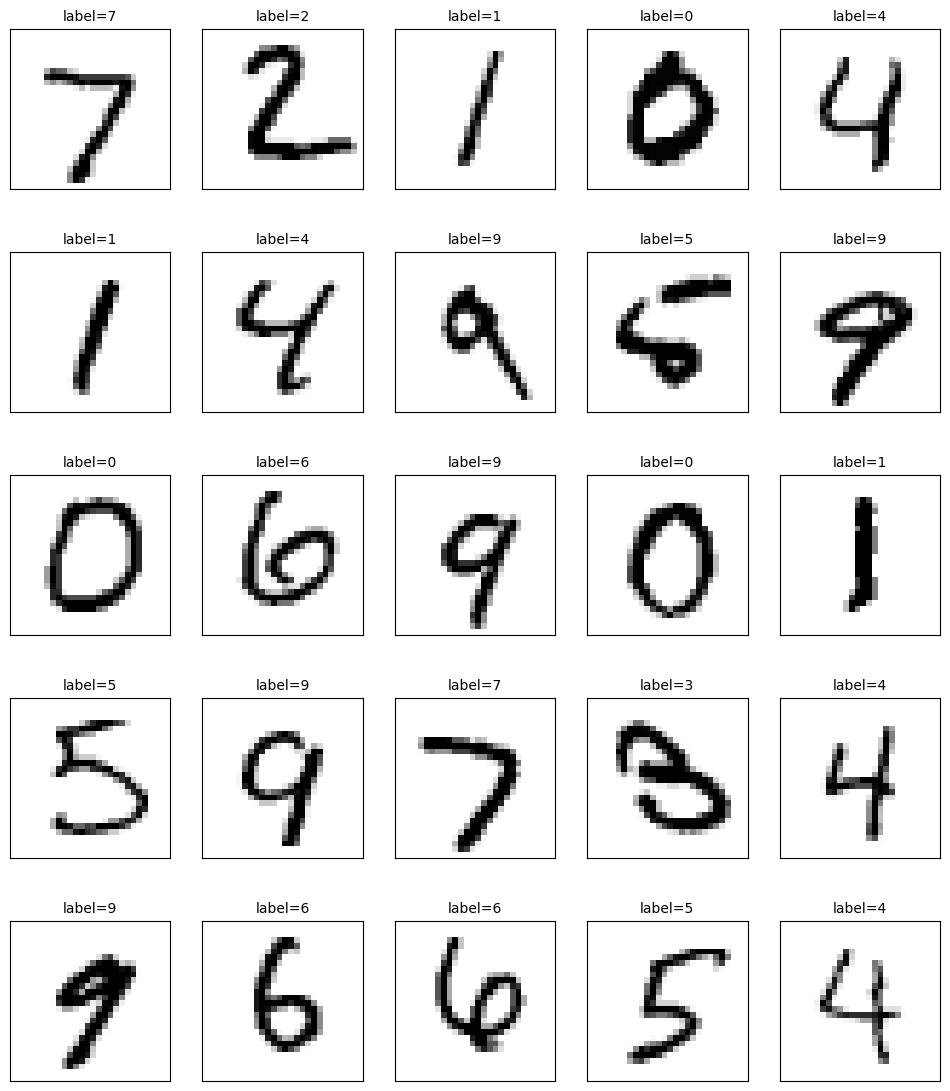

In [21]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num=25
    for i in range(0, num):
        ax=plt.subplot(5, 5, i+1)
        ax.imshow(images[idx], cmap='binary')
        title="label=" + str(labels[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]);
        ax.set_yticks([]);
        idx += 1
    plt.show()

plot_images_labels_prediction(x_test_image, y_test_label, predictions, 0, 25)


Finally, we use a function to plot the test images along with their predicted labels. This will give us a visual representation of how well our model is performing.

That's it! We have successfully trained a quantization-aware model, converted it to the TFLite format, and performed inference using the TensorFlow Lite interpreter.






# Convert your model to Orion's Cairo code

In [22]:
import numpy as np
import tensorflow as tf
import os


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="q_aware_model.tflite")
interpreter.allocate_tensors()

# Create an object that with all weights and biases
params = {
    "fc1_weights": interpreter.get_tensor(1), 
    "fc1_bias": interpreter.get_tensor(2), 
    "fc2_weights": interpreter.get_tensor(4), 
    "fc2_bias": interpreter.get_tensor(5)
}

# Create the directory if it doesn't exist
os.makedirs('src/generated', exist_ok=True)

for param_name, param in params.items():
    with open(os.path.join('src', 'generated', f"{param_name}.cairo"), "w") as f:
        f.write(
            "use array::ArrayTrait;\n" +
            "use orion::operators::tensor::core::{TensorTrait, Tensor};\n" +
            "use orion::operators::tensor::implementations::impl_tensor_i32;\n" +
            "use orion::numbers::signed_integer::{integer_trait::IntegerTrait, i32::i32};\n\n" +
            "fn {0}() -> Tensor<i32> ".format(param_name) + "{\n" +
            "    let mut shape = ArrayTrait::<usize>::new();\n"
        )
        for dim in param.shape:
            f.write("    shape.append({0});\n".format(dim))
        f.write(
            "    let mut data = ArrayTrait::<i32>::new();\n"
        )
        for val in np.nditer(param.flatten()):
            f.write("    data.append(IntegerTrait::new({0}, {1}));\n".format(abs(int(val)), str(val < 0).lower()))
        f.write(
            "    TensorTrait::new(shape.span(), data.span())\n" +
            "}\n"
        )
      
with open(os.path.join('src', 'generated.cairo'), 'w') as f:
    for param_name in params.keys():
        f.write(f"mod {param_name};\n")
